In [11]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import csv

## Problema da Geleria de Arte

### Modelar a galeria como um grafo planar, considerando a forma do polígono.
Cada aresta é uma parede e cada vértice é um ponto de interseção entre paredes. 

In [12]:
def read_coordinates_csv(file_path):
    coordinates = {}
    with open(file_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            vertex_id = int(row['id'])
            x, y = int(row['x']), int(row['y'])
            coordinates[vertex_id] = (x, y)
    return coordinates

In [13]:
def create_gallery_with_custom_edges(coordinates):
    gallery_graph = nx.Graph()
    gallery_graph.add_nodes_from(coordinates.keys())

    edges = [(i, i + 1) for i in range(0, len(coordinates)-1)]  
    edges.append((len(coordinates)-1, 0))

    gallery_graph.add_edges_from(edges)

    return gallery_graph

In [14]:
def draw_graph_with_custom_coordinates(graph, coordinates):
    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(graph, coordinates, node_size=250, node_color="lightblue", edgecolors="black")
    nx.draw_networkx_edges(graph, coordinates, width=2, edge_color="gray")

    labels = {node: i for i, node in enumerate(graph.nodes())}
    nx.draw_networkx_labels(graph, coordinates, labels=labels, font_size=10, font_color="black")


    plt.title("Galeria de Arte", fontsize=16)
    plt.axis("off")
    plt.show()

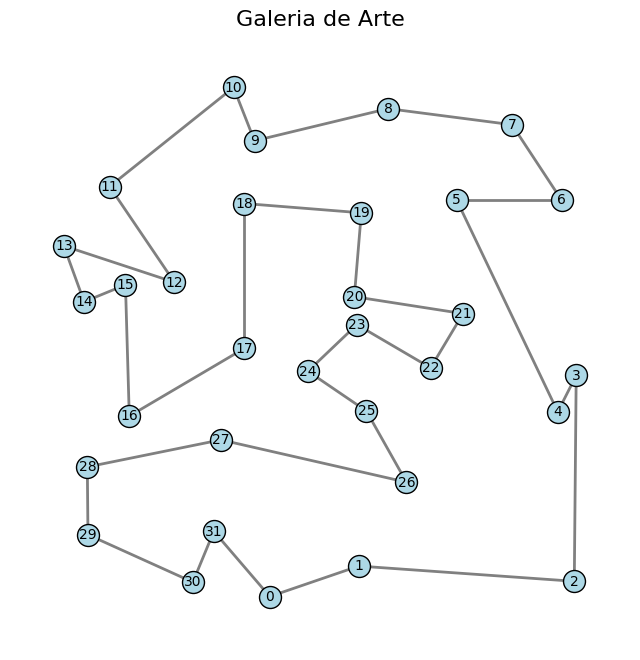

In [ ]:
coordinates = read_coordinates_csv("data/coordinates_32nodes.csv")
graph = create_gallery_with_custom_edges(coordinates)

draw_graph_with_custom_coordinates(graph, coordinates)


### Seleção de guardas

#### Algoritmo de corte de orelhas (Ear Clipping Algorithm) - Triangulação
Algoritmo para conseguir fazer a triangulação de um polígono simples. O algoritmo consiste em cortar o polígono em triângulos, removendo uma orelha por vez.

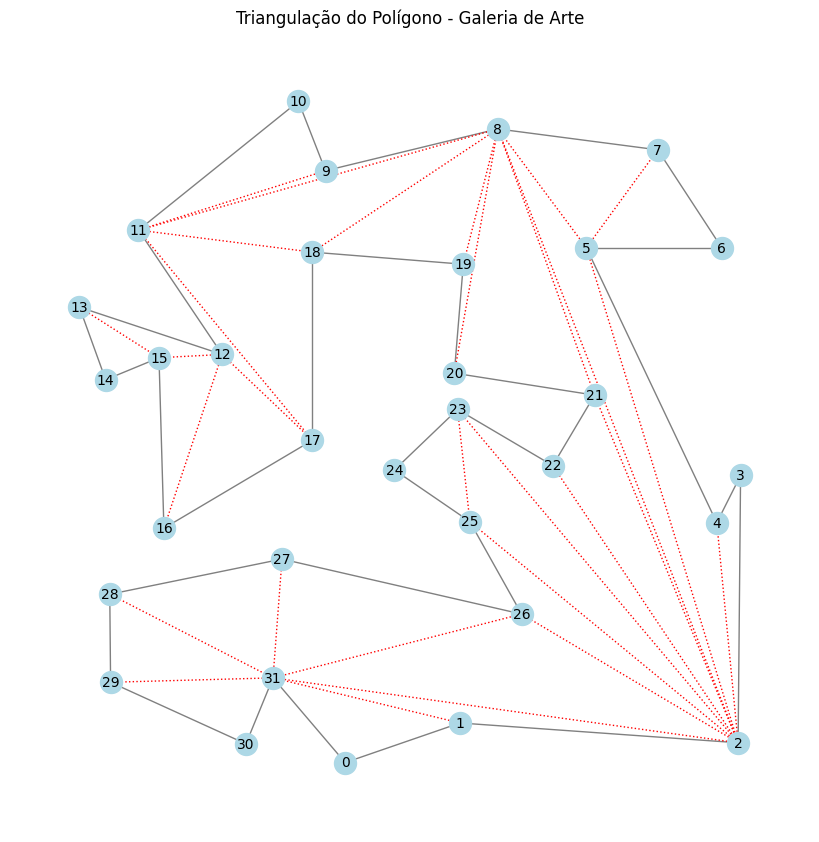

In [18]:
def is_ear(polygon, i, j, k):
    """Verifica se os vértices i, j, k formam uma 'orelha'."""
    a, b, c = polygon[i], polygon[j], polygon[k]
    cross_product = (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])
    if cross_product <= 0:
        return False  
    for p in polygon:
        if np.allclose(p, a) or np.allclose(p, b) or np.allclose(p, c):
            continue
        if point_in_triangle(p, a, b, c):
            return False
    return True

def point_in_triangle(pt, v1, v2, v3):
    """Verifica se um ponto está dentro de um triângulo."""
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
    
    b1 = sign(pt, v1, v2) < 0.0
    b2 = sign(pt, v2, v3) < 0.0
    b3 = sign(pt, v3, v1) < 0.0
    return b1 == b2 == b3

def triangulate_polygon(polygon):
    """Triangulação de um polígono simples usando o algoritmo de corte de orelhas."""
    n = len(polygon)
    if n < 3:
        return []  
    indices = list(range(0, n))  
    triangles = []
    while len(indices) > 3:
        for i in range(len(indices)):
            i_prev = indices[i - 1]
            i_curr = indices[i]
            i_next = indices[(i+1) % len(indices)]
            if is_ear(polygon, i_prev, i_curr, i_next):
                triangles.append((i_prev, i_curr, i_next))
                del indices[i]  
                break
    triangles.append((indices[0], indices[1], indices[2]))
    return triangles

polygon_coords = list(coordinates.values())

triangles = triangulate_polygon(polygon_coords)

tri_edges = set()
for t in triangles:
    tri_edges.update({(t[0], t[1]), (t[1], t[2]), (t[2], t[0])})

edges = [(i, i + 1) for i in range(0, len(coordinates)-1)]
edges.append((0,len(coordinates)-1))

dotted_edges = {tuple(sorted((u, v))) for u, v in tri_edges} - set(edges)

plt.figure(figsize=(8, 8))
nx.draw(graph, pos=coordinates, with_labels=True, font_size=10, node_color="lightblue", node_size=250, edge_color="gray")

dotted_edges_list = [(u, v) for u, v in dotted_edges]

nx.draw_networkx_edges(
    graph,
    pos=coordinates,
    edgelist=dotted_edges_list,
    style="dotted",
    edge_color="red"
)


plt.title("Triangulação do Polígono - Galeria de Arte")
plt.show()


Polígono após a triangulação

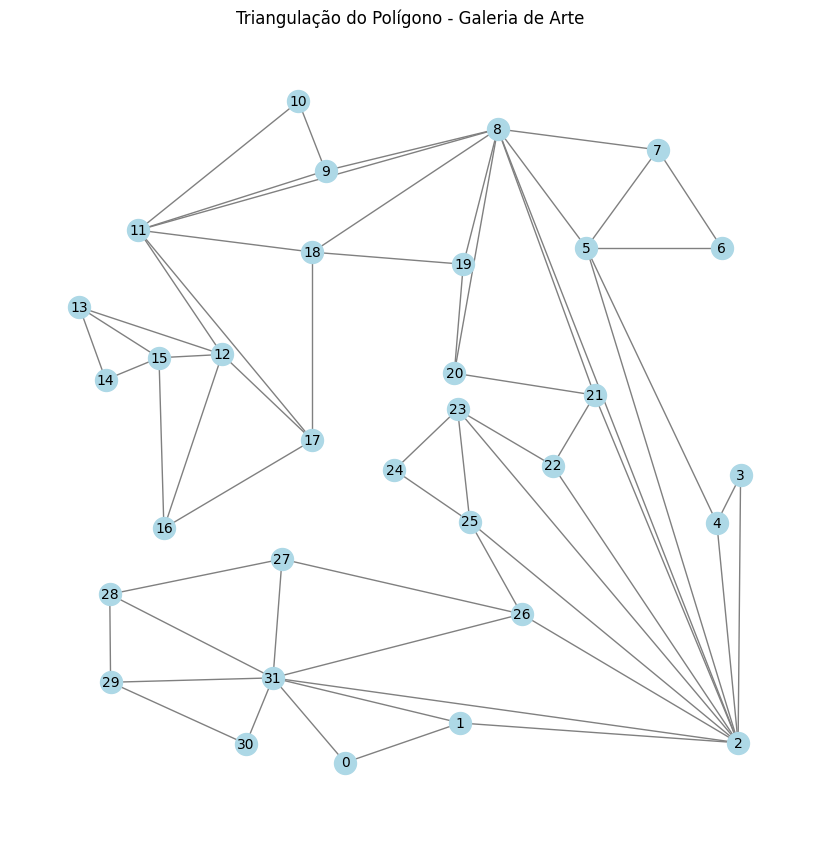

In [19]:
new_graph = nx.Graph()

new_graph.add_nodes_from(graph.nodes)
new_graph.add_edges_from(edges + list(dotted_edges))

plt.figure(figsize=(8, 8))
nx.draw(new_graph, pos=coordinates, with_labels=True,font_size=10, node_color="lightblue", node_size=250, edge_color="gray")
plt.title("Triangulação do Polígono - Galeria de Arte")
plt.show()


### Criação da árvore dos triângulos
Nesse grafo, cada nó corresponde a um triângulo da triangulação, enquanto cada aresta conecta dois triângulos que compartilham uma diagonal.

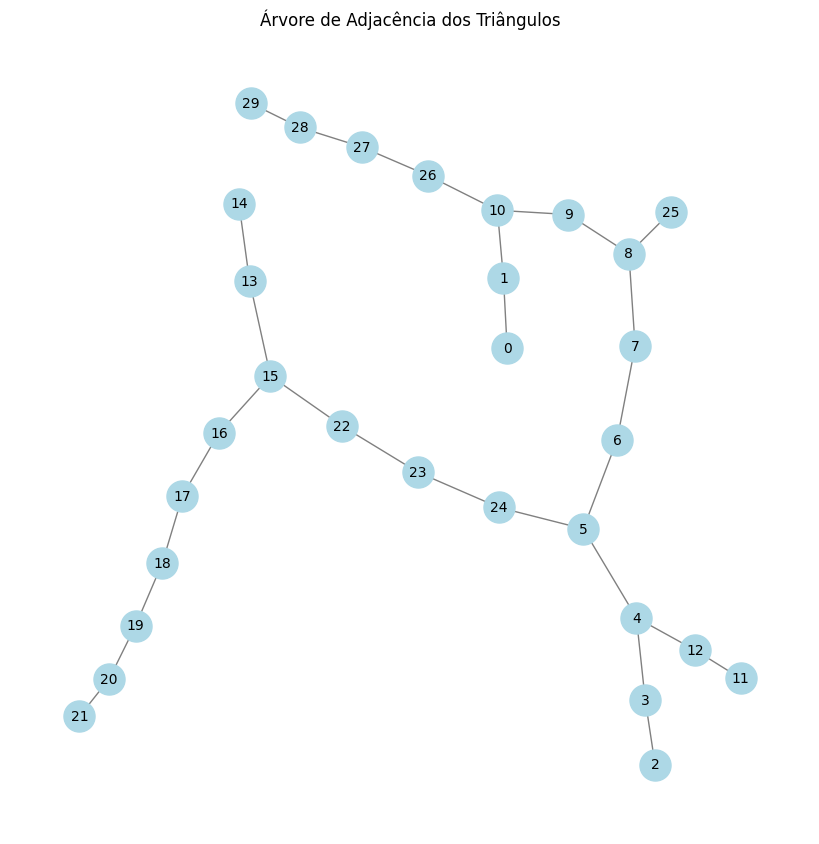

In [ ]:
from collections import defaultdict

def build_triangle_tree(graph):
    edge_to_triangles = defaultdict(list)
    
    triangles = []
    for triangle in nx.find_cliques(graph):
        if len(triangle) == 3:
            triangles.append(triangle)
            edges = [(triangle[0], triangle[1]), (triangle[1], triangle[2]), (triangle[2], triangle[0])]
            for edge in edges:
                edge_to_triangles[tuple(sorted(edge))].append(len(triangles) - 1)
    
    triangle_tree = nx.Graph()
    for triangle_index, triangle in enumerate(triangles):
        triangle_tree.add_node(triangle_index)
        for edge in [(triangle[0], triangle[1]), (triangle[1], triangle[2]), (triangle[2], triangle[0])]:
            shared_triangles = edge_to_triangles[tuple(sorted(edge))]
            for neighbor in shared_triangles:
                if neighbor != triangle_index:
                    triangle_tree.add_edge(triangle_index, neighbor)
    
    return triangle_tree, triangles

triangle_tree, triangles = build_triangle_tree(new_graph)

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(triangle_tree)
nx.draw(
    triangle_tree,
    pos,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    edge_color="gray",
    font_size=10,
)
plt.title("Árvore de Adjacência dos Triângulos")
plt.show()

Visualização da árvore gerada disposta no polígono da galeria

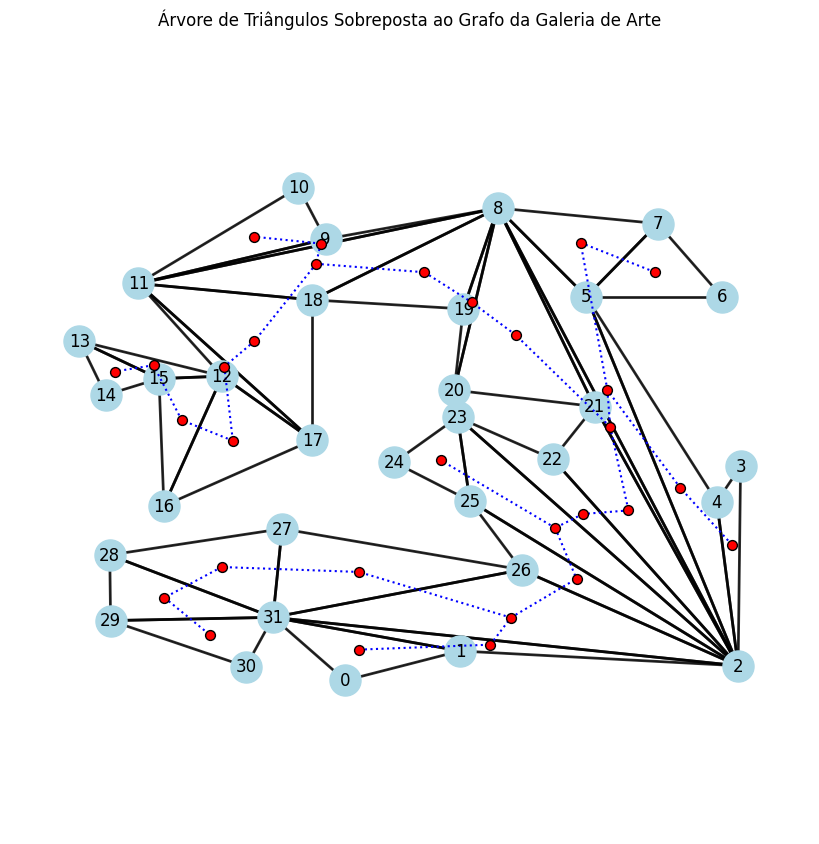

In [ ]:
def visualize_triangles_on_original_graph_no_labels(new_graph, triangle_tree, triangles, coordinates):
    plt.figure(figsize=(8, 8))

    nx.draw(new_graph, pos=coordinates, with_labels=True, node_color="lightblue", node_size=500, edge_color="gray")

    for triangle in triangles:
        tri_edges = [(triangle[0], triangle[1]), (triangle[1], triangle[2]), (triangle[2], triangle[0])]
        nx.draw_networkx_edges(
            new_graph,
            pos=coordinates,
            edgelist=tri_edges,
            edge_color="black",
            width=2,
            alpha=0.8,
        )

    for edge in triangle_tree.edges:
        tri1 = triangles[edge[0]]
        tri2 = triangles[edge[1]]

        tri1_center = tuple(
            sum(coordinates[v][i] for v in tri1) / 3 for i in range(2)
        )
        tri2_center = tuple(
            sum(coordinates[v][i] for v in tri2) / 3 for i in range(2)
        )
        plt.plot(
            [tri1_center[0], tri2_center[0]],
            [tri1_center[1], tri2_center[1]],
            color="blue",
            linestyle="dotted",
            alpha=1,
        )

    for idx, triangle in enumerate(triangles):
        tri_center = tuple(
            sum(coordinates[v][i] for v in triangle) / 3 for i in range(2)
        )
        plt.scatter(tri_center[0], tri_center[1], color="red", edgecolor="black", s=50, zorder=3)

    plt.title("Árvore de Triângulos Sobreposta ao Grafo da Galeria de Arte")
    plt.axis("equal")
    plt.show()


visualize_triangles_on_original_graph_no_labels(new_graph, triangle_tree, triangles, coordinates)

### DFS para gerar a coloração dos vértices 

In [ ]:
def dfs_coloring_corrected(triangle_tree, triangles, graph):
    vertex_colors = {node: None for node in graph.nodes}
    available_colors = [1, 2, 3]
    visited_triangles = set()

    def dfs(triangle_index):
        if triangle_index in visited_triangles:
            return  

        visited_triangles.add(triangle_index)

        triangle = triangles[triangle_index]

        for vertex in triangle:
            if vertex_colors[vertex] is None:  
                used_colors = {vertex_colors[neighbor] for neighbor in graph.neighbors(vertex) if vertex_colors[neighbor] is not None}
                for color in available_colors:
                    if color not in used_colors:
                        vertex_colors[vertex] = color
                        break

        for neighbor in triangle_tree.neighbors(triangle_index):
            dfs(neighbor)
            
    dfs(0)
    return vertex_colors


vertex_colors_corrected = dfs_coloring_corrected(triangle_tree, triangles, new_graph)

Cores atribuídas aos vértices após correção final: {0: 1, 1: 2, 2: 1, 3: 2, 4: 3, 5: 2, 6: 3, 7: 1, 8: 3, 9: 1, 10: 3, 11: 2, 12: 1, 13: 2, 14: 1, 15: 3, 16: 2, 17: 3, 18: 1, 19: 2, 20: 1, 21: 2, 22: 3, 23: 2, 24: 1, 25: 3, 26: 2, 27: 1, 28: 2, 29: 1, 30: 2, 31: 3}


Visualização da coloração dos vértices

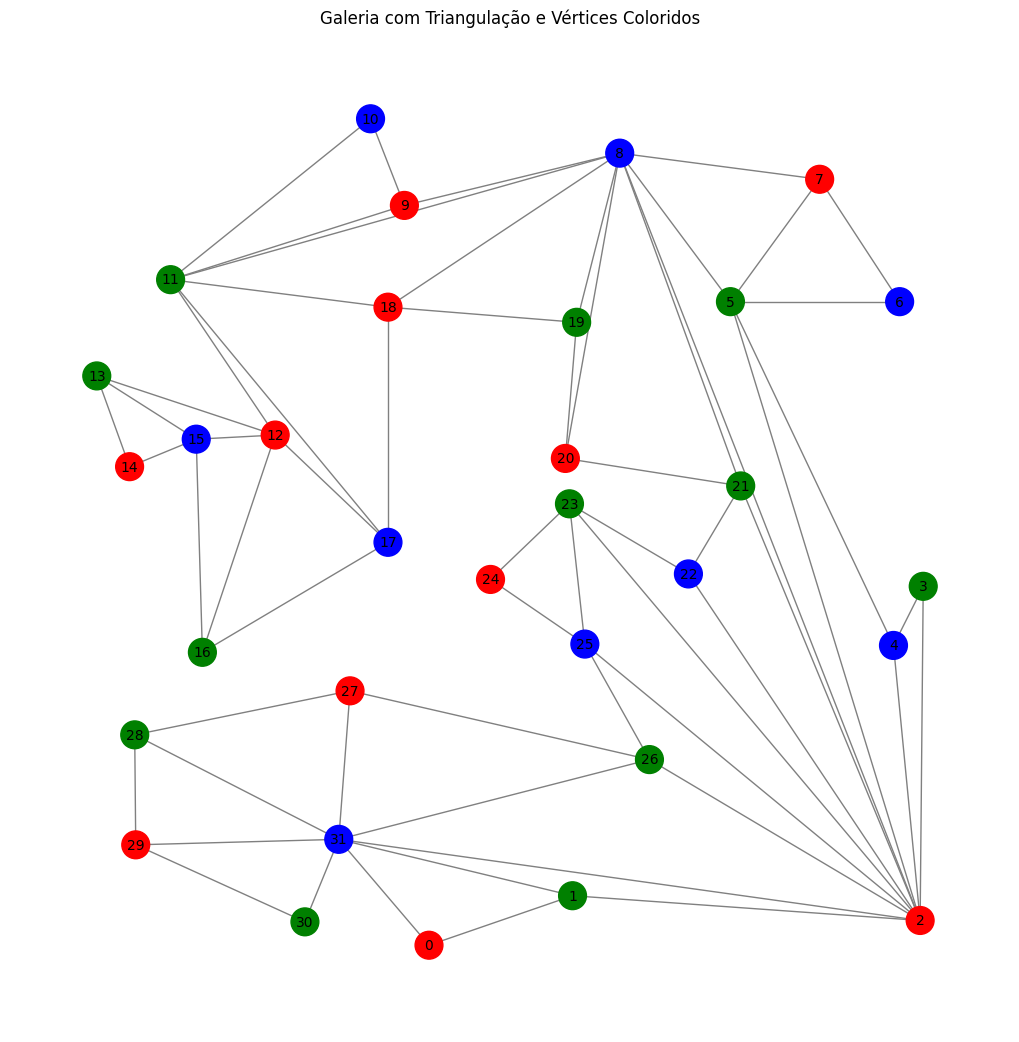

In [ ]:
def visualize_colored_graph(graph, vertex_colors, coordinates):
    color_map = {1: "red", 2: "green", 3: "blue", None: "gray"}
    node_colors = [color_map[vertex_colors[node]] for node in graph.nodes]

    plt.figure(figsize=(10, 10))
    nx.draw(
        graph,
        pos=coordinates,
        with_labels=True,
        node_color=node_colors,
        node_size=400,
        edge_color="gray",
        font_size=10,
    )
    plt.title("Galeria com Triangulação e Vértices Coloridos")
    plt.show()


visualize_colored_graph(new_graph, vertex_colors_corrected, coordinates)


Visualização dos vértices selecionados para guardas

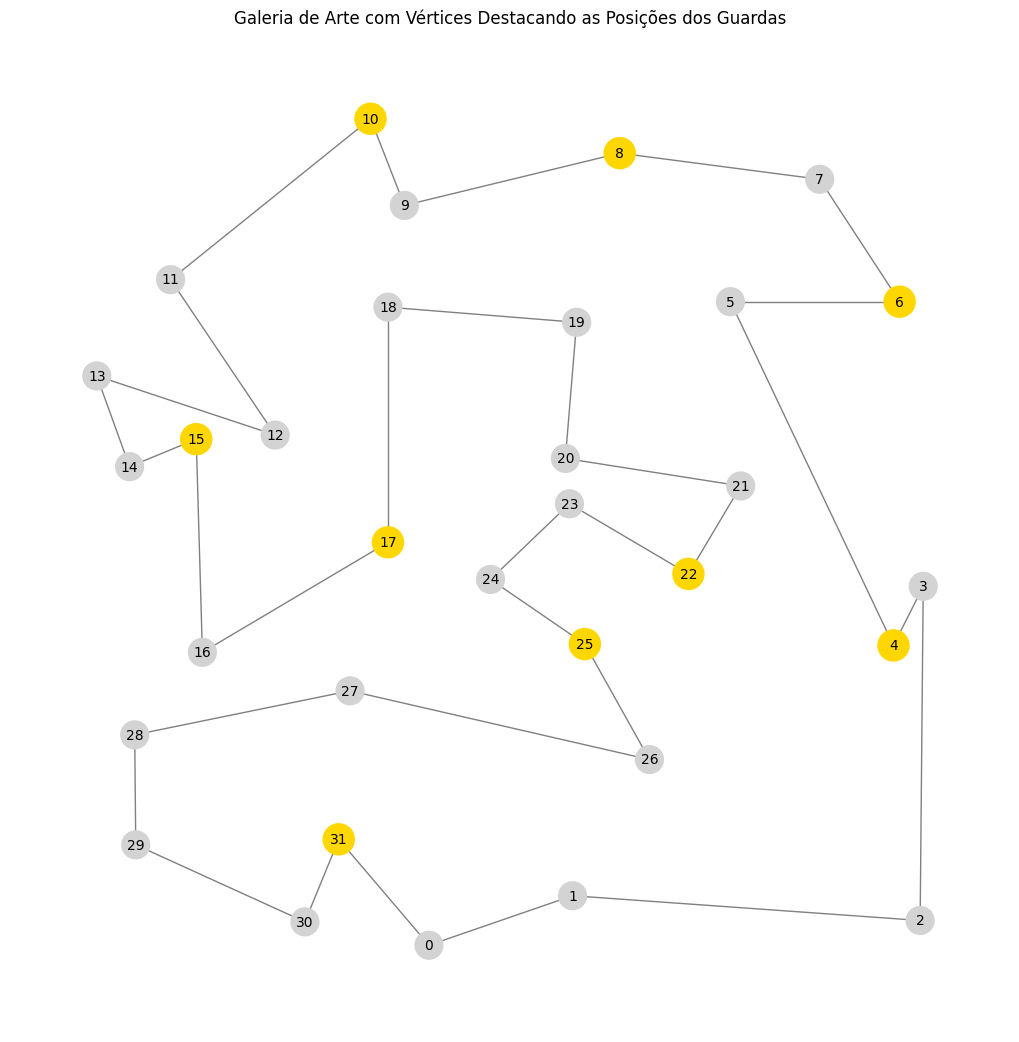

In [ ]:
def visualize_winner_color_highlighted(graph, vertex_colors, coordinates):
    color_counts = {1: 0, 2: 0, 3: 0}
    for color in vertex_colors.values():
        if color in color_counts:
            color_counts[color] += 1

    winner_color = min(color_counts, key=color_counts.get)

    node_colors = []
    node_sizes = []

    for node in graph.nodes:
        if vertex_colors[node] == winner_color:
            node_colors.append("gold")  
            node_sizes.append(500)  
        else:
            node_colors.append("lightgray")  
            node_sizes.append(400)

    plt.figure(figsize=(10, 10))
    nx.draw(
        graph,
        pos=coordinates,
        with_labels=True,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color="gray",
        font_size=10,
    )
    plt.title("Galeria de Arte com Vértices Destacando as Posições dos Guardas")
    plt.show()

    return color_counts

color_counts = visualize_winner_color_highlighted(graph, vertex_colors_corrected, coordinates)
